# PROJETO DESAFIO
##### PRIMEIRA PARTE UTILIZANDO TENSORFLOW PARA CLASSIFICAÇÃO DAS IMAGENS
O projeto a seguir foi desenvolvido baseado nos seguintes tutoriais:
* Classificação de imagem: https://www.tensorflow.org/tutorials/images/classification?hl=pt-br
* Carregar e pré-processar imagens: https://www.tensorflow.org/tutorials/load_data/images?hl=pt-br

A base de dados utilizada foi obtida no desafio Image Matching Challenge 2023, da Kaggle: https://www.kaggle.com/competitions/image-matching-challenge-2023

Professor: David

Alunos:
* Eduardo Albino Gonelli
* Matheus Kiss
* Rafael Tome
* Renato Lins da Palma

## DESCRIÇÃO DA ATIVIDADE
O projeto consiste das partes:
* 1) Configuração do ambiente
* 2) Download do dataset e carregamento do dataset
* 4) Treinamento para reconhecimento de imagens
* 5) Extração de dados das imagens
* 6) Reconstrução das imagens em formato tridimensional

## CONFIGURAÇÃO DO AMBIENTE

In [ ]:
# upload do arquivo kaggle.json com a chave da API para uso do dataset
from google.colab import files
files.upload()

In [ ]:
# criação do diretório para os arquivos do kaggle
! mkdir ~/.kaggle
# cópia do arquivo json para a pasta criada
! cp kaggle.json ~/.kaggle/
# segurança para visualização do arquivo json
# (4 e 2 "6" somente proprietário pode ler e modificar, 00 os demais colaboradores não têm acesso)
! chmod 600 ~/.kaggle/kaggle.json
! chmod 600 /content/kaggle.json
# se deu certo, permite a visualização das listas de dataset
! kaggle datasets list

ref                                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                             Spotify and Youtube                                 9MB  2023-03-20 15:43:25           8828        319  1.0              
ppb00x/country-gdp                                                Country_GDP                                         7KB  2023-04-07 06:47:36           1308         38  1.0              
erdemtaha/cancer-data                                             Cancer Data                                        49KB  2023-03-22 07:57:00           4033         94  1.0              
omartorres25/honda-data                                     

## DOWNLOAD DO DATASET

In [ ]:
!kaggle competitions download -c image-matching-challenge-2022

100% 2.31G/2.31G [00:26<00:00, 107MB/s]
100% 2.31G/2.31G [00:26<00:00, 92.8MB/s]


In [ ]:
# descompacta o dataset na raiz da pasta local
!unzip image-matching-challenge-2022.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train/buckingham_palace/images/42572558_3847795752.jpg  
  inflating: train/buckingham_palace/images/43210627_10009473243.jpg  
  inflating: train/buckingham_palace/images/43583354_7506898338.jpg  
  inflating: train/buckingham_palace/images/43641758_9015255137.jpg  
  inflating: train/buckingham_palace/images/43728242_3176119914.jpg  
  inflating: train/buckingham_palace/images/43847879_5656257946.jpg  
  inflating: train/buckingham_palace/images/44446238_9117834424.jpg  
  inflating: train/buckingham_palace/images/44573130_5715131949.jpg  
  inflating: train/buckingham_palace/images/44579495_1325305773.jpg  
  inflating: train/buckingham_palace/images/44944081_6780023064.jpg  
  inflating: train/buckingham_palace/images/45136306_6779959250.jpg  
  inflating: train/buckingham_palace/images/45439163_5667030438.jpg  
  inflating: train/buckingham_palace/images/45955845_8872058158.jpg  
  inflating: train/buckingham_

In [ ]:
# importa as bibliotecas essenciais para trabalhar com tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### CARREGAMENTO DO DATASET

In [ ]:
import pathlib
train_dir = pathlib.Path('/content/train')
test_dir = pathlib.Path('/content/test_images')

In [ ]:
image_count = len(list(train_dir.glob('*/images/*.jpg')))
print(f"Imagens de treinamento: {image_count}")

Imagens de treinamento: 5678


In [ ]:
test_image_count = len(list(test_dir.glob('*/*.png')))
print(f"Imagens de teste: {test_image_count}")

Imagens de teste: 6


### EXPLORANDO O CONJUNTO DE DADOS

In [ ]:
locality = 'british_museum'
locality_path = train_dir / locality
locality_images = list(locality_path.glob('images/*.jpg'))

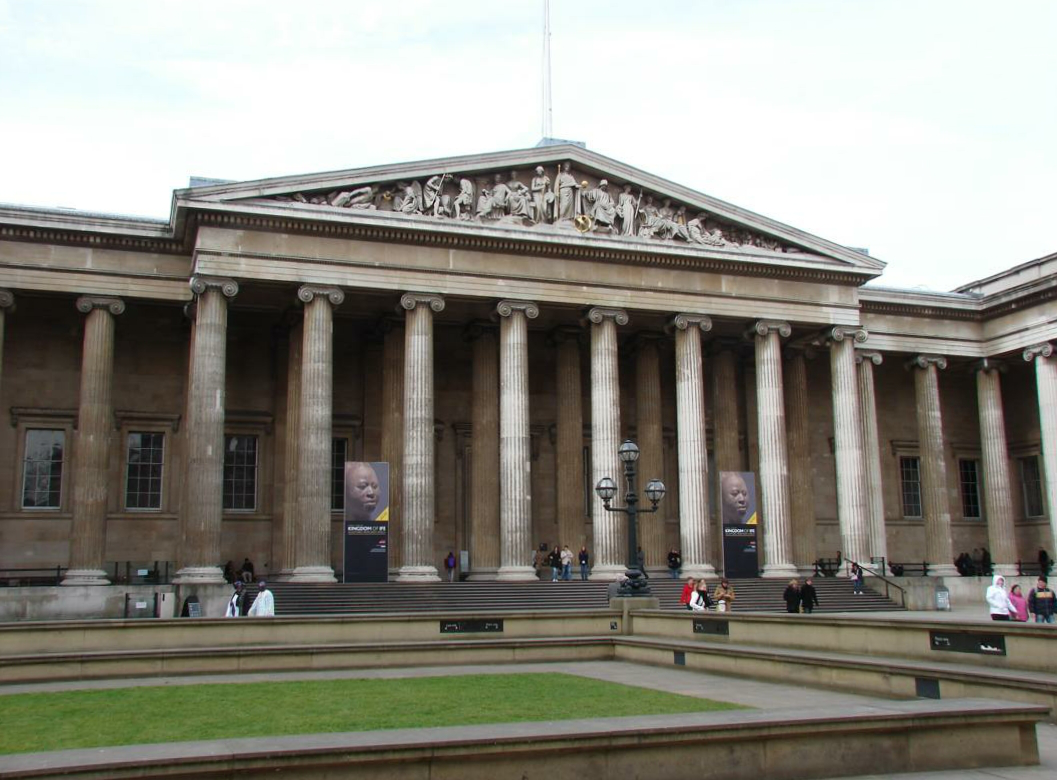

In [ ]:
image_to_show = locality_images[0]
PIL.Image.open(str(image_to_show))

### CRIANDO O CONJUNTO DE DADOS PARA TREINAMENTO

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
# cria o conjunto de dados para treinamento e validação do treinamento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='categorical',
  class_names=None,
  color_mode='rgb',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=123,
  validation_split=0.2,
  subset="training",
  interpolation='bilinear',
  follow_links=False,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='categorical',
  class_names=None,
  color_mode='rgb',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=123,
  validation_split=0.2,
  subset="validation",
  interpolation='bilinear',
  follow_links=False,
)

class_names = train_ds.class_names
print(class_names)

Found 5678 files belonging to 16 classes.
Using 4543 files for training.
Found 5678 files belonging to 16 classes.
Using 1135 files for validation.
['brandenburg_gate', 'british_museum', 'buckingham_palace', 'colosseum_exterior', 'grand_place_brussels', 'lincoln_memorial_statue', 'notre_dame_front_facade', 'pantheon_exterior', 'piazza_san_marco', 'sacre_coeur', 'sagrada_familia', 'st_pauls_cathedral', 'st_peters_square', 'taj_mahal', 'temple_nara_japan', 'trevi_fountain']


### VISUALIZAÇÃO DOS DADOS

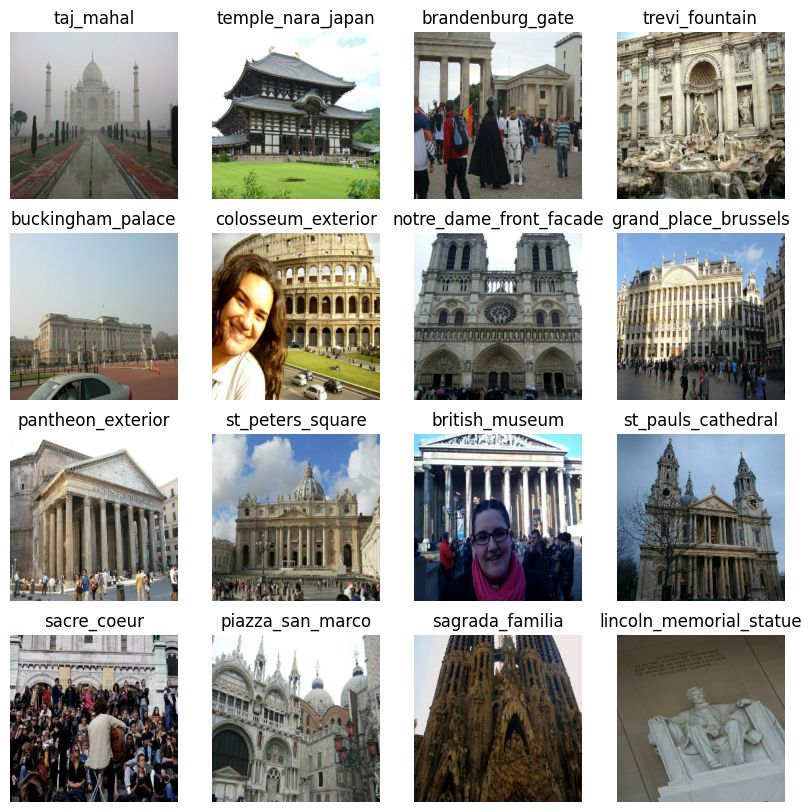

In [ ]:
num_classes = len(class_names)
num_cols = 4
num_rows = num_classes // num_cols + (1 if num_classes % num_cols != 0 else 0)

plt.figure(figsize=(10, 10))

images_shown = set()

for images, labels in train_ds:
    for i in range(images.shape[0]):
        if len(images_shown) == num_classes:
            break

        label = np.argmax(labels[i])
        if label not in images_shown:
            images_shown.add(label)
            ax = plt.subplot(num_rows, num_cols, len(images_shown))
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[label])
            plt.axis("off")

    if len(images_shown) == num_classes:
        break

### CONFIGURANDO OS DADOS PARA DESEMPENHO E PADRONIZANDO OS DADOS

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### CRIAÇÃO DO MODELO

In [ ]:
num_classes = len(class_names)

model = Sequential([
  # camada de entrada
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # camadas ocultas
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # camada de saída
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# compila o modelo com o otimizador adam
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# exibe o resumo do modelo
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 64)       

### TREINAMENTO DO MODELO

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10
142/142 [==============================] - 412s 3s/step - loss: 2.2004 - accuracy: 0.3249 - val_loss: 1.5096 - val_accuracy: 0.5665
Epoch 2/10
142/142 [==============================] - 396s 3s/step - loss: 1.1196 - accuracy: 0.6672 - val_loss: 1.2351 - val_accuracy: 0.6396
Epoch 3/10
142/142 [==============================] - 398s 3s/step - loss: 0.6245 - accuracy: 0.8160 - val_loss: 1.0674 - val_accuracy: 0.7101
Epoch 4/10
142/142 [==============================] - 397s 3s/step - loss: 0.2804 - accuracy: 0.9201 - val_loss: 1.3473 - val_accuracy: 0.6987
Epoch 5/10
142/142 [==============================] - 408s 3s/step - loss: 0.0936 - accuracy: 0.9747 - val_loss: 1.4065 - val_accuracy: 0.7128
Epoch 6/10
142/142 [==============================] - 392s 3s/step - loss: 0.0345 - accuracy: 0.9927 - val_loss: 1.5518 - val_accuracy: 0.7093
Epoch 7/10
142/142 [==============================] - 408s 3s/step - loss: 0.0369 - accuracy: 0.9905 - val_loss: 1.7676 - val_accuracy: 0.7048

### VISUALIZAÇÃO DO TREINAMENTO

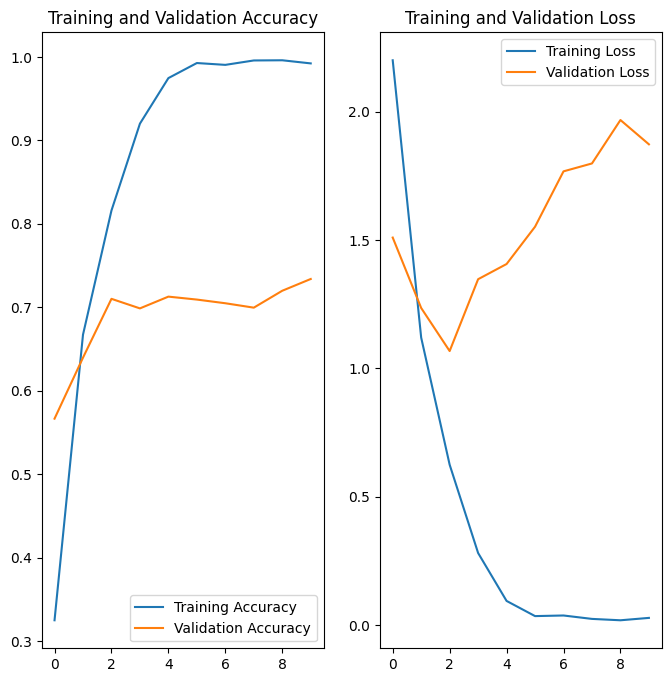

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observa-se no treinamento acima que a acurácia de treinamento está muito alta comparada a acurácia de validação, o que indica overfitting. Observa-se também que a perda na validação também está alta. Para tentar resolver, usar-se-á aumento de dados.

### DATA AUGMENTATION

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

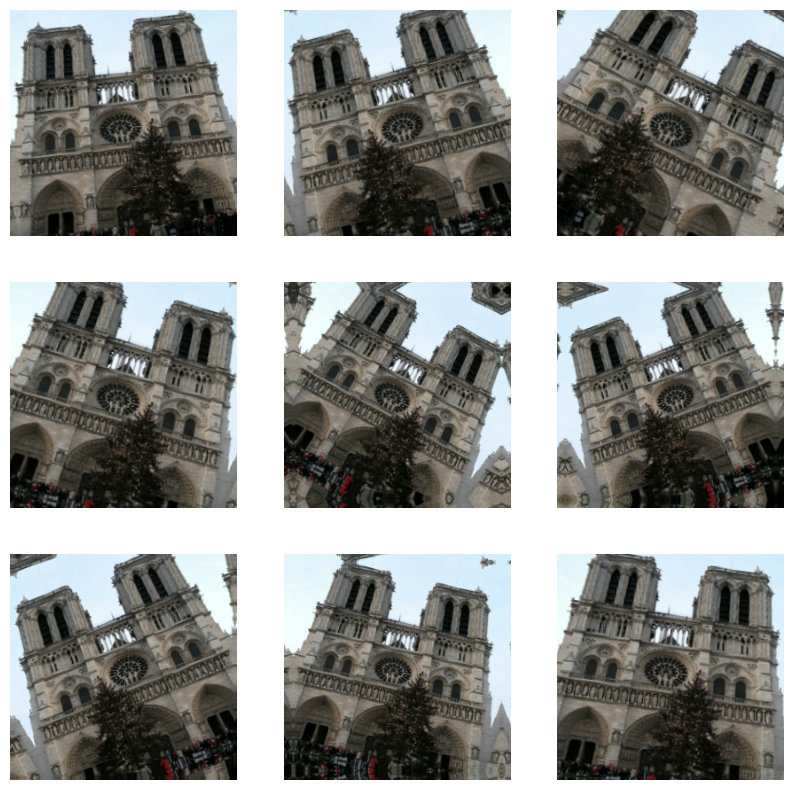

In [ ]:
# exibe uma imagem aplicando o data_augmentation nele.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### MODELO COM DATA AUGMENTATION

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# compila o modelo com o otimizador adam
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
142/142 [==============================] - 454s 3s/step - loss: 2.2365 - accuracy: 0.3086 - val_loss: 1.6809 - val_accuracy: 0.5066
Epoch 2/15
142/142 [==============================] - 462s 3s/step - loss: 1.6149 - accuracy: 0.5144 - val_loss: 1.3819 - val_accuracy: 0.5859
Epoch 3/15
142/142 [==============================] - 452s 3s/step - loss: 1.2921 - accuracy: 0.6075 - val_loss: 1.1370 - val_accuracy: 0.6643
Epoch 4/15
142/142 [==============================] - 464s 3s/step - loss: 1.0749 - accuracy: 0.6716 - val_loss: 1.1055 - val_accuracy: 0.6546
Epoch 5/15
142/142 [==============================] - 449s 3s/step - loss: 0.9240 - accuracy: 0.7271 - val_loss: 1.0008 - val_accuracy: 0.6996
Epoch 6/15
142/142 [==============================] - 464s 3s/step - loss: 0.7965 - accuracy: 0.7616 - val_loss: 1.0920 - val_accuracy: 0.6722
Epoch 7/15
142/142 [==============================] - 468s 3s/step - loss: 0.7191 - accuracy: 0.7856 - val_loss: 1.0011 - val_accuracy: 0.6987

### VISUALIZAÇÃO DOS DADOS APÓS O TREINAMENTO COM DATA AUGMENTATION

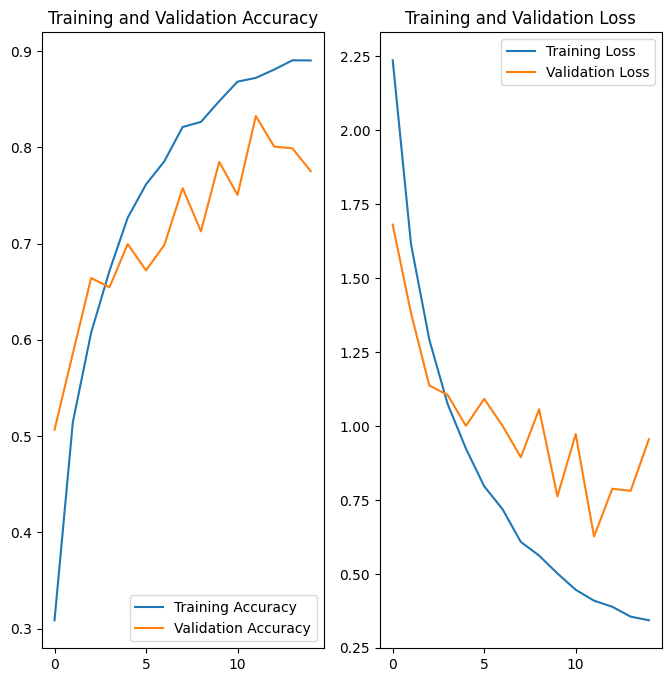

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Percebe-se claramente que a qualidade do treinamento aumentou bastante!

### TESTANDO COM UMA IMAGEM EXTRAÍDA DA INTERNET

In [ ]:
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image_path = '/content/train/brandenburg_gate/images/02749394_3866382383.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 52ms/step
This image most likely belongs to brandenburg_gate with a 15.29 percent confidence.


In [ ]:
image_path = '/content/g_p_bruxelas.png'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 52ms/step
This image most likely belongs to buckingham_palace with a 15.34 percent confidence.


In [ ]:
image_path = '/content/train/trevi_fountain/images/00358444_4165248133.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 87ms/step
This image most likely belongs to trevi_fountain with a 15.31 percent confidence.


In [ ]:
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image_path = '/content/Trevi_Fountain.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 53ms/step
This image most likely belongs to trevi_fountain with a 15.22 percent confidence.
